In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import trange
import glob,os
from tensorflow.python.client import device_lib

import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
from skimage.transform import downscale_local_mean
#device_lib.list_local_devices()

In [2]:
for f in glob.glob('images/ffjord/*.png'):
    os.remove(f)

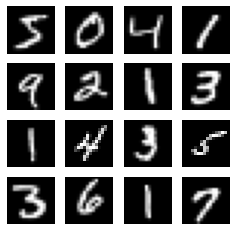

In [3]:
# resizing images to make training easier
(train_images, train_labels), (validate_images,validate_labels) = tf.keras.datasets.mnist.load_data()
train_images =train_images.reshape([-1,28,28,1]).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_images = tf.image.resize(train_images,[16,16])
train_images_flattened = tf.reshape(train_images,[-1,16*16])

fig = plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(train_images[i]*127.5+127.5, cmap = 'gray')
    plt.axis('off')
    
BUFFER_SIZE=train_images.shape[0]
BATCH_SIZE=128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images_flattened).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [4]:
class ResnetUpSampleBlock(tf.keras.layers.Layer):
    def __init__(self, filter_size,kernel_size):
        super(ResnetUpSampleBlock, self).__init__(name='')
        
        self.conv2a = tf.keras.layers.Conv2DTranspose(filter_size, kernel_size=(3, 3), strides=(1,1), 
                                                      padding='same',use_bias=False)
        self.bn2a = tf.keras.layers.BatchNormalization()

        self.conv2b = tf.keras.layers.Conv2DTranspose(filter_size, kernel_size, strides=(2,2), 
                                                      padding='same',use_bias=False)
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.conv2c = tf.keras.layers.Conv2DTranspose(filter_size, kernel_size=(3, 3),strides=(1,1), 
                                                      padding='same',use_bias=False)
        self.bn2c = tf.keras.layers.BatchNormalization()
        
        self.convReshape = tf.keras.layers.Conv2DTranspose(filter_size,kernel_size=(1,1),strides=(2,2),
                                                 padding='same',use_bias=False)

    def call(self, input_tensor):
        x = self.conv2a(input_tensor)
        x = self.bn2a(x)
        x = tf.nn.relu(x)

        x = self.conv2b(x)
        x = self.bn2b(x)
        x = tf.nn.relu(x)

        x = self.conv2c(x)
        x = self.bn2c(x)
    
        input_tensor_reshaped = self.convReshape(input_tensor)
        x += input_tensor_reshaped
        return tf.nn.relu(x)
    
class ResnetDownSampleBlock(tf.keras.layers.Layer):
    def __init__(self,filter_size, kernel_size):
        super(ResnetDownSampleBlock, self).__init__(name='')

        self.conv2a = tf.keras.layers.Conv2D(filter_size, kernel_size=(3, 3), strides=(1,1),
                                             padding='same',use_bias=False)
        self.bn2a = tf.keras.layers.BatchNormalization()

        self.conv2b = tf.keras.layers.Conv2D(filter_size, kernel_size, strides=(2,2), 
                                             padding='same',use_bias=False)
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.conv2c = tf.keras.layers.Conv2D(filter_size, kernel_size=(3, 3),strides=(1,1), 
                                             padding='same',use_bias=False)
        self.bn2c = tf.keras.layers.BatchNormalization()
        
        self.convReshape = tf.keras.layers.Conv2D(filter_size,kernel_size=(1,1),strides=(2,2),
                                                 padding='same',use_bias=False)

    def call(self, input_tensor):
        x = self.conv2a(input_tensor)
        x = self.bn2a(x)
        x = tf.nn.leaky_relu(x)

        x = self.conv2b(x)
        x = self.bn2b(x)
        x = tf.nn.leaky_relu(x)

        x = self.conv2c(x)
        x = self.bn2c(x)
        
        input_tensor_reshaped = self.convReshape(input_tensor)
        x += input_tensor_reshaped
        return tf.nn.leaky_relu(x)

In [5]:
output_dim = 16*16
class MLP_ODE(tf.keras.Model):
    
    def __init__(self,name='mlp_ode'):
        super(MLP_ODE,self).__init__(name=name)
        self.model = tf.keras.Sequential()
        self.model.add(layers.Reshape((16,16,2),input_shape=(2*output_dim,)))
        assert self.model.output_shape == (None,16,16,2) 
        self.model.add(ResnetDownSampleBlock(64,3))
        assert self.model.output_shape == (None,8,8,64)
        self.model.add(ResnetDownSampleBlock(128,3))
        assert self.model.output_shape == (None,4,4,128)
        self.model.add(ResnetUpSampleBlock(128,3))
        assert self.model.output_shape == (None,8,8,128)
        self.model.add(layers.BatchNormalization())
        self.model.add(ResnetUpSampleBlock(64,3))
        assert self.model.output_shape == (None,16,16,64)
        self.model.add(layers.BatchNormalization())
        # data scaled from -1 to 1 so use tanh 
        self.model.add(layers.Conv2DTranspose(1, (1, 1), strides=(1, 1), 
                                         padding='same', use_bias=False, activation='tanh'))
        assert self.model.output_shape == (None, 16 ,16, 1)
        self.model.add(layers.Flatten())
        assert self.model.output_shape == (None, output_dim)
     
    def call(self, t, inputs):
        inputs = tf.concat([tf.broadcast_to(t, inputs.shape), inputs], -1)
        return self.model(inputs)
                  
solver = tfp.math.ode.DormandPrince(atol=1e-5)
ode_solve_fn = solver.solve
trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson
state_time_fn = MLP_ODE()
ffjord_bijector = tfb.FFJORD(
                      state_time_derivative_fn = state_time_fn,
                      ode_solve_fn=ode_solve_fn,
                      trace_augmentation_fn=trace_augmentation_fn)              
                  
ref_dist = tfd.MultivariateNormalDiag(loc=tf.zeros(output_dim,tf.float32),
                                      scale_diag = tf.ones(output_dim,tf.float32))
                  
flow = tfd.TransformedDistribution(distribution=ref_dist,
                                   bijector=ffjord_bijector)

In [6]:
@tf.function
def train_step(target_sample):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(flow.log_prob(target_sample))
    gradients = tape.gradient(loss,flow.trainable_variables)
    optimizer.apply_gradients(zip(gradients,flow.trainable_variables))
    return loss

@tf.function
def sample(N):
    return tf.reshape(flow.sample(N),[-1,16,16])

def save_samples(epoch):
    images = sample(16)
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i]*127.5+127.5, cmap = 'gray')
        plt.axis('off')
    plt.suptitle('epoch: %03d'%(epoch))
    plt.savefig('images/ffjord/image_at_epoch_{:04d}.png'.format(epoch))
    plt.close(fig)
    
def train(dataset,num_epochs):
        t = trange(num_epochs)
        loss_history = []
        for epoch in t:
            for batch in dataset:
                loss = train_step(batch)
                t.set_description("loss: %0.3f " % loss.numpy())
                t.refresh()
                loss_history.append(loss.numpy())
            state_time_fn.trainable = False
            save_samples(epoch)
            state_time_fn.trainable = True
        return loss_history

In [7]:
LR = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
EPOCHS = 100
loss_history = train(train_dataset,EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


loss: 257.942 :   1%|          | 1/100 [1:38:39<162:46:25, 5919.05s/it]


KeyboardInterrupt: 

In [8]:
state_time_fn.trainable = False
def plot_samples():
    images = sample(16)
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i]*127.5+127.5, cmap = 'gray')
        plt.axis('off')
    plt.pause(0.5)

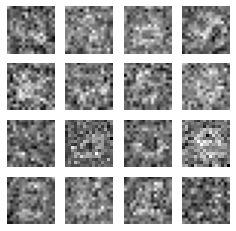

In [9]:
plot_samples()

In [ ]:
import glob
import imageio
anim_file = 'ffjord.gif'

with imageio.get_writer(anim_file, mode='I',fps=1) as writer:
    filenames = glob.glob('images/ffjord/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)